# **DSCI 100 Project Final Report: [003-24]**

## **Introduction**

A UBC research group is conducting a study that analyzes how people play video games. So they set up a Minecraft server, and collected data on all the players that signed up to play. We were given two data sets, one with information of players (players.csv), and another with information of play sessions (session.csv). 

For our project, we try to answer the question: **what "kinds" of players are most likely to contribute a large amount of data?** We want to look at information about the players and see if we can build some sort of model that can predict their playtime. To do this, we only require the players.csv dataset, since we are only concerned with information about players. 

This dataset has 196 observations, each corresponding to an individual player. It consists of 9 variables, 2 of which - *individualId* and *organizationName* - contain no values for any observation (probably for the purpose of user confidentiality). So, we consider 7 of the 9 variables:

- *experience:* This variable is of type character and its values in the data are one of 'Beginner',  'Amateur', 'Regular', 'Pro', or 'Veteran'. This represents the player's experience. 
- *subscribe:* This variable is of type logical vector, and its values are either TRUE or FALSE.
- *hashedEmail:* This variable is of type character, and it represents the player's email in a hashed form.
- *played_hours:* This variable is of type double, and it represents the number of hours a player has played.
- *name:* This variable is of type character, and holds the player's name.
- *gender:* This variable is of type character, and its values in the data are one of 'Male', 'Female', 'Non-Binary', 'Agender', 'Two-Spirited', 'Other', and 'Prefer not to say'.
- *age:* This variable is of type double, and it represents the player's age.

Taking a first look at this data, we would definitely want to turn the *experience* and *gender* variables into factors, if we were to use them for prediction. The data for *played_hours* was probably collected using an automated system that records the number of hours each player has played. For the rest of the variables, the players inputted the information themselves. Therefore, we'd have to consider the biases of the values inputted. Furthermore, *experience* is subjective to the rationale of the player, so there could be two players with similar experience levels who have selected different options for experience.

## **Methods and Results**

We want to use the variables *age* and *experience* to attempt to predict *played_hours*. We plan to build 2 different models, using the following methods: knn classification and knn regression. Then, we will analyze the strength of each model.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### **1. Knn Classification**

### Reading and Tidying Data
The code below loads the data from the ```players.csv``` file. The ```experience``` is converted to a categorical variable and  ```played_hours``` column is then converted from numeric to a categorical variable by binning. 

In [2]:
player_data <- read_csv("data/players.csv") |>
    mutate(experience = as.factor(experience))

player_data <- player_data |> 
    mutate(cat_hours = cut(played_hours, breaks = c(-Inf,1,3,10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, Inf)))

player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName,cat_hours
<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA,"(30,40]"
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA,"(3,10]"
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA,"(-Inf,1]"
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA,"(-Inf,1]"
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA,"(1,3]"
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA,"(-Inf,1]"


### Splitting Data
The data is then split into a training and testing dataset using a 75% split.

In [3]:
set.seed(3456) 

hours_split <- initial_split(player_data, prop = 0.75, strata = cat_hours)  
hours_train <- training(hours_split)   
hours_test <- testing(hours_split)

### Creating the Workflow
To design the workflow, first a recipe was created that predicts the number of hours a user will play based on their age and experience.
<br>
We then perform a 5-fold cross-validation
<br>
Then for the creation of the model, the number of neighbors (*K*) has to be decided. In order to do this, all *K* values between 1 and 10 were tested

In [4]:
hours_recipe <- recipe(cat_hours ~ age + experience, data = hours_train) |>
   step_scale(all_numeric_predictors()) |>
   step_center(all_numeric_predictors())

hours_vfold <- vfold_cv(hours_train, v = 5, strata = cat_hours)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
      add_recipe(hours_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = hours_vfold, grid = k_vals) |>
      collect_metrics()

knn_results

→ A | warning: ✖ No observations were detected in `truth` for levels: (20,30], (30,40],
                 (40,50], (50,60], (60,70], (70,80], (80,90], (90,100], (100,150], (150,200],
                 and (200, Inf].
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: ✖ No observations were detected in `truth` for levels: (10,15], (15,20],
                 (20,30], (40,50], (50,60], (60,70], (70,80], (80,90], (90,100], (150,200],
                 and (200, Inf].
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

→ C | warning: ✖ No observations were detected in `truth` for levels: (3,10], (10,15],
                 (15,20], (20,30], (30,40], (40,50], (60,70], (70,80], (80,90], (90,100],
                 (100,150], (150,200], and (200, Inf].
               ℹ Computation will proceed by 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6194089,5,0.04912055,Preprocessor1_Model01
1,roc_auc,hand_till,0.4822850,5,0.01419655,Preprocessor1_Model01
2,accuracy,multiclass,0.5996388,5,0.04144515,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.5320558,5,0.02488400,Preprocessor1_Model09
10,accuracy,multiclass,0.7962562,5,0.02363525,Preprocessor1_Model10
10,roc_auc,hand_till,0.5367802,5,0.01268470,Preprocessor1_Model10


### *K* Value Selection
In order to select the best *K* value, the accuarcies of each *K* value between 1 and 10 were plotted. The most accurate *K* was then selected to use for our model. ```K=6```

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,multiclass,0.7962562,5,0.02363525,Preprocessor1_Model06


[1] 6

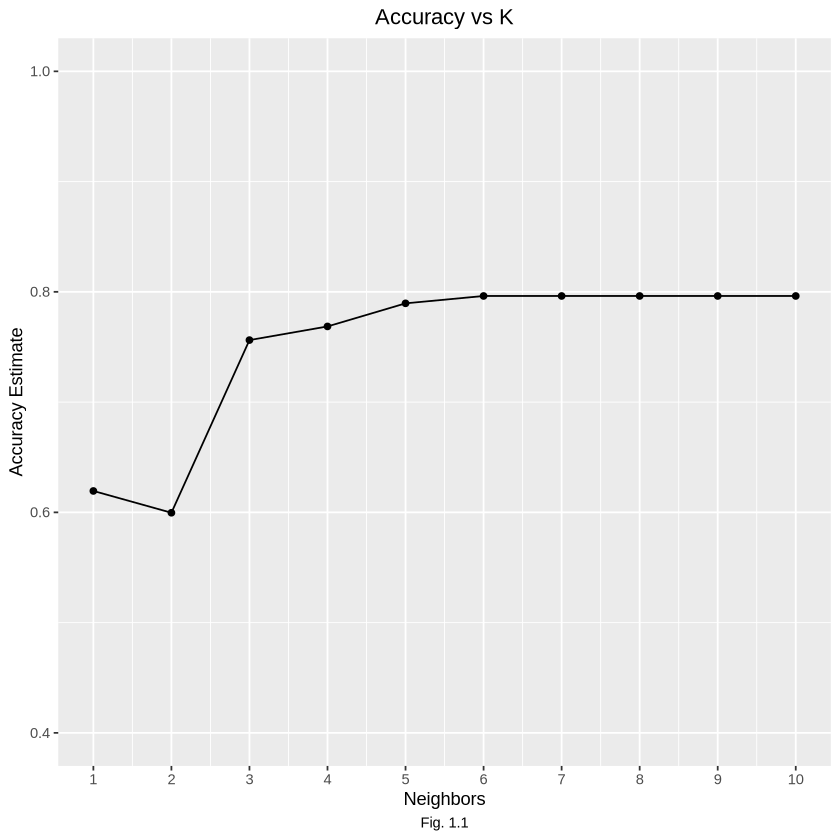

In [5]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs K", caption = "Fig. 1.1") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis
      theme(
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(hjust = 0.5))

accuracy_versus_k

best_accuracy_train <- accuracies |> 
  filter(mean == max(mean))  %>% slice(1)

best_accuracy_train

best_k <- best_accuracy_train$neighbors

best_k

### Final Model
The ```knn_hours``` model is created using the most accurate value of K and then trained on the training dataset.

In [6]:
set.seed(2020)

knn_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
      set_engine("kknn") |>
      set_mode("classification")

hours_fit <- workflow() |>
      add_recipe(hours_recipe) |>
      add_model(knn_hours) |>
      fit(data = hours_train)

hours_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1836735
Best kernel: rectangular
Best k: 6

### Testing Model
The model is then tested on the Testing dataset and the accuracy of the predictions is measured.
<br>
Our model shows us an 81.6% accuracy on the testing dataset.

In [7]:
hours_test_predictions <- predict(hours_fit , hours_test) |>
      bind_cols(hours_test)

hours_test_accuracy <- hours_test_predictions |>
    metrics(truth = cat_hours, estimate = .pred_class)

# BEST ACCURACY ON TEST DATA

hours_test_predictions
hours_test_accuracy


.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName,cat_hours
<fct>,<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<fct>
"(-Inf,1]",Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA,"(-Inf,1]"
"(-Inf,1]",Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,NA,NA,"(-Inf,1]"
"(-Inf,1]",Veteran,TRUE,bbe2d83de678f519c4b3daa7265e683b4fe2d814077f9094afd11d8f217039ec,0.0,Nyla,Female,22,NA,NA,"(-Inf,1]"
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
"(-Inf,1]",Pro,FALSE,f7875ae87a61632030d5c4029ee8cf081be7047b2b4a9c04ab5a706f59786197,0.2,Liam,Male,17,NA,NA,"(-Inf,1]"
"(-Inf,1]",Beginner,TRUE,8c9d043ebb3689e679a37bfed30ea96272bcd14689ed2d9fcd68a4ae0c1663bc,0.0,Lina,Female,17,NA,NA,"(-Inf,1]"
"(-Inf,1]",Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22,NA,NA,"(-Inf,1]"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.81632653
kap,multiclass,-0.02320186


The model also has 79.6% accuracy on the training dataset

In [8]:
# BEST ACCURACY ON TRAIN DATA
best_accuracy_test <- best_accuracy_train |>
    select(.metric,.estimator,mean)
best_accuracy_test

.metric,.estimator,mean
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7962562


### Prediction Accuracy
To further investigate the accuracy of our model's prediction we investigated which predictions by our model were correct as compared to which our model got wrong. *Fig 1.2* displays the ```played_hours``` vs ```age``` and whether the model was accurate. From this it is evident that the model was only accurate predicting low hour values. We discuss this further in the discussion.

.pred_class,count
<fct>,<int>
"(-Inf,1]",48
"(1,3]",1


cat_hours,count
<fct>,<int>
"(-Inf,1]",160
"(1,3]",17
"(3,10]",6
⋮,⋮
"(100,150]",1
"(150,200]",1
"(200, Inf]",2


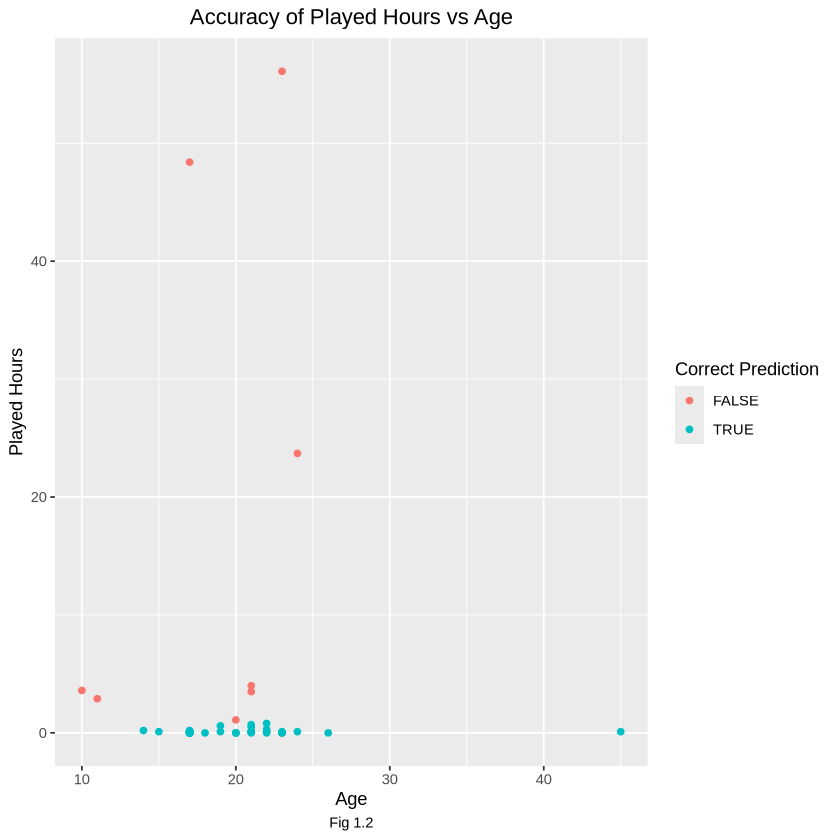

In [9]:
hours_test_predictions <- hours_test_predictions |>
    mutate(correct_pred = (cat_hours == .pred_class))
hours_test_plot <- hours_test_predictions |>
    ggplot(aes(x = age, y = played_hours, colour = correct_pred)) +
    geom_point() +
    labs(title = "Accuracy of Played Hours vs Age", caption = "Fig 1.2", x="Age", y="Played Hours", color="Correct Prediction") +
    theme(
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(hjust = 0.5))
hours_test_plot

hours_test_summary <- hours_test_predictions |>
    group_by(.pred_class) |>
    summarize(count = n())
hours_test_summary

player_data_summary <- player_data |>
    group_by(cat_hours) |>
    summarize(count = n())
player_data_summary

### **2. Knn Regression**

In [10]:
players <- read_csv("data/players.csv")
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [11]:
players_clean <- players %>% select(experience, played_hours, age )
players_clean$experience <- factor(players_clean$experience, levels = c("Beginner","Amateur", "Regular", "Pro", "Veteran"), ordered = TRUE)
players_clean$experience <- as.numeric(players_clean$experience)
players_clean

experience,played_hours,age
<dbl>,<dbl>,<dbl>
4,30.3,9
5,3.8,17
5,0.0,17
⋮,⋮,⋮
2,0.0,17
2,2.3,17
4,0.2,91


### Data splitting

In [12]:
set.seed(2000)
players_split <- initial_split(players_clean, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

### EDA

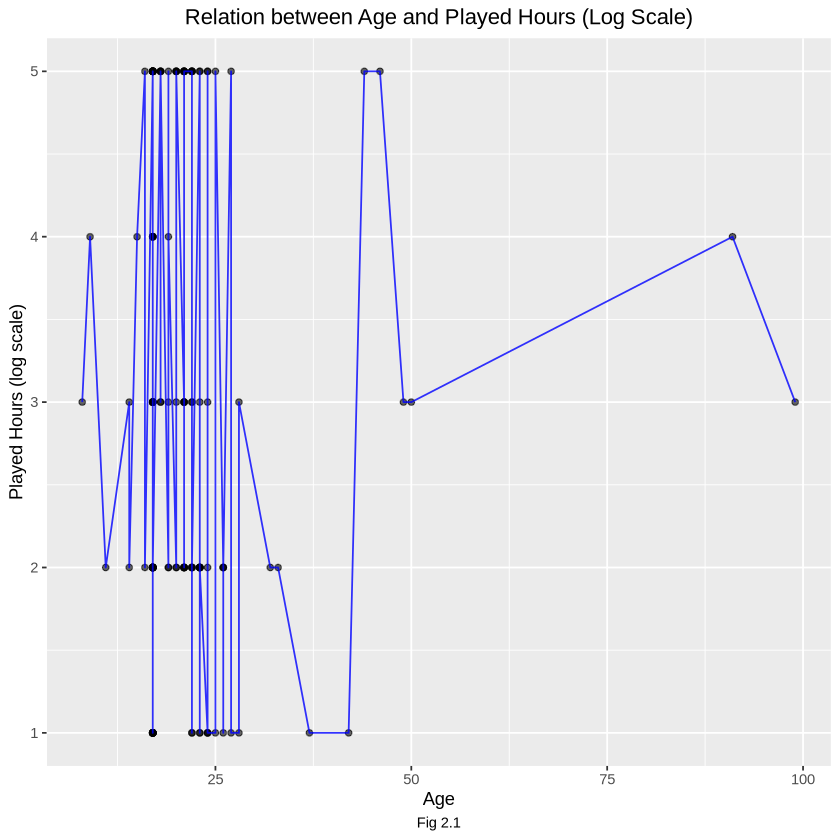

In [13]:
ggplot(players_training, aes(x = age, y = experience)) +
  geom_point(color = "black", alpha = 0.6) + 
  geom_line(color = "blue", alpha = 0.8) +  
  labs(
    title = "Relation between Age and Played Hours (Log Scale)",
    x = "Age",
    y = "Played Hours (log scale)",
    caption = "Fig 2.1"
  ) +
  theme(
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(hjust = 0.5))


### KNN - Training, evaluating, and tuning the model

In [14]:
players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")


In [15]:
players_recipe <- recipe( played_hours ~ ., data = players_training) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_vfold <- vfold_cv(players_training, v =7, strata = played_hours)

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [16]:
gridvals <- tibble(neighbors = seq(from = 1, to = 110, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,8.411341,7,1.553276,Preprocessor1_Model001
2,rmse,standard,8.723761,7,1.404187,Preprocessor1_Model002
3,rmse,standard,8.582697,7,1.471119,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
108,rmse,standard,8.040104,7,1.382815,Preprocessor1_Model108
109,rmse,standard,8.040422,7,1.383480,Preprocessor1_Model109
110,rmse,standard,8.039485,7,1.385545,Preprocessor1_Model110


### Find the kmin

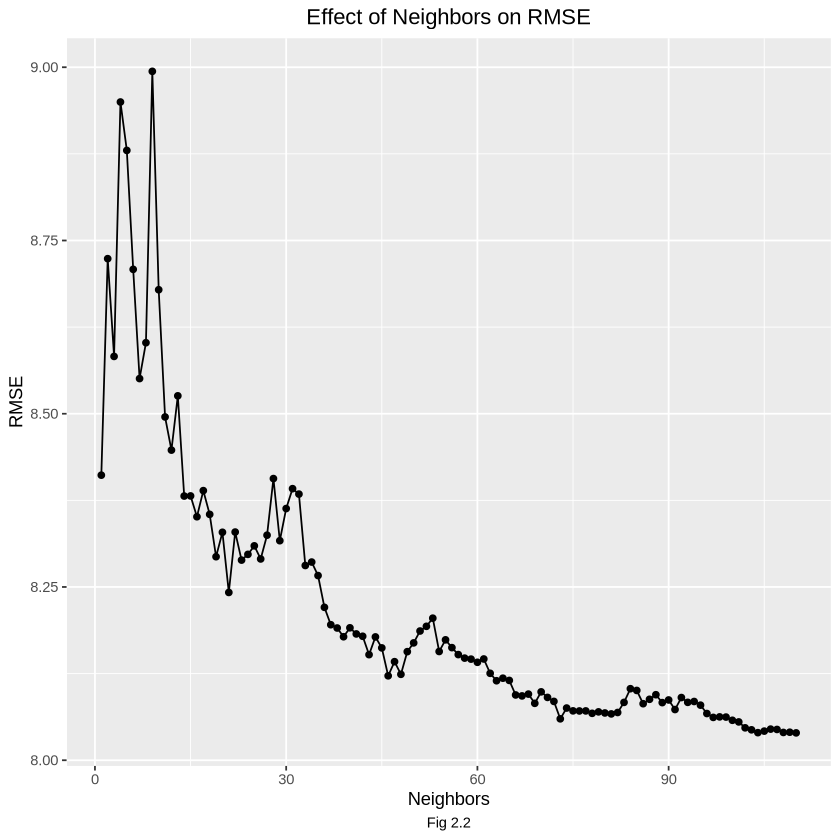

In [17]:
ggplot(players_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    title = "Effect of Neighbors on RMSE",
    x = "Neighbors",
    y = "RMSE",
    caption = "Fig 2.2"
  ) +
   theme(
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(hjust = 0.5))

In [18]:
best_neighbors <- players_results |>
  filter(mean == min(mean)) |> 
  pull(neighbors)


best_neighbors

[1] 110

In [19]:
players_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbors) |>
  set_engine("kknn") |>
  set_mode("regression")

players_workflow_best <- players_workflow |>
  update_model(players_spec_best)

knn_fit <- players_workflow_best |>
  fit(data = players_training)

players_testing_with_pred <- knn_fit |>
  predict(players_testing) |>
  bind_cols(players_testing)

print(players_testing_with_pred)

# A tibble: 50 × 4
   .pred experience played_hours   age
   <dbl>      <dbl>        <dbl> <dbl>
 1  2.65          3          0      19
 2  2.87          2          0.1    17
 3  2.74          4          0      17
 4  2.74          5          0      17
 5  2.87          1          0      17
 6  2.87          2          0.5    17
 7  2.87          2          0.1    17
 8  2.64          3        218.     20
 9  2.87          2          0.9    18
10  2.74          2          0.2    27
# ℹ 40 more rows


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


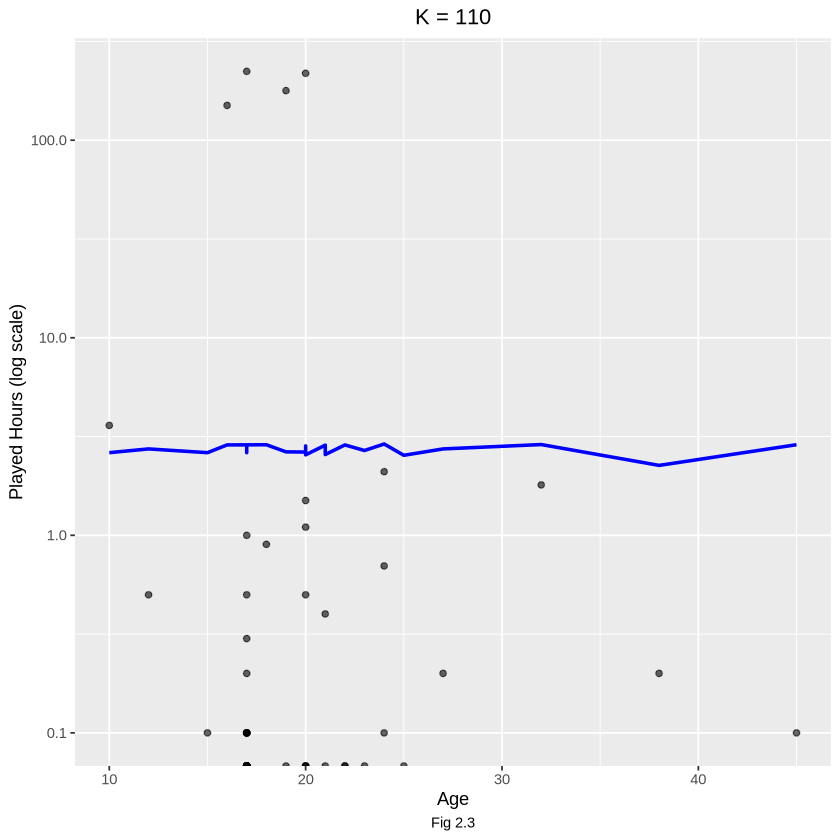

In [20]:
ggplot(players_testing_with_pred, aes(x = age, y = played_hours)) +
  geom_point(color = "black", alpha = 0.6) +  # true data points
  geom_line(aes(y = .pred), color = "blue", size = 1) +  # predicted line
  scale_y_log10() +  # Apply log scale
  labs(
    title = paste("K =", best_neighbors),  
    x = "Age",
    y = "Played Hours (log scale)",
    caption = "Fig 2.3"
  ) +
  theme(
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(hjust = 0.5))


### KNN - Evaluating on the test set

In [21]:

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 75) |>
set_engine("kknn") |>
  set_mode("regression")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_training)

knn_summary_testing <- knn_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')
print("Knn fit on test datas")
knn_summary_testing

knn_summary_training <- knn_fit |>
  predict(players_training) |>
  bind_cols(players_training) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

print("Knn fit on train datas")
knn_summary_training

[1] "Knn fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.13917


[1] "Knn fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.665761


### LINEAR REG -  Training, evaluating, and tuning the model

In [22]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe <- recipe(played_hours ~ ., data = players_training)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = players_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)   experience          age  
    4.91211     -0.62410     -0.02669  


In [23]:
lm_test_results <- lm_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred)|>
  filter(.metric == 'rmse')
print("Fit on test datas")
lm_test_results

lm_train_results <- lm_fit |>
  predict(players_training) |>
  bind_cols(players_training) |>
  metrics(truth = played_hours, estimate = .pred)|>
  filter(.metric == 'rmse')
print("Fit on train datas")
lm_train_results

[1] "Fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.37322


[1] "Fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.622914


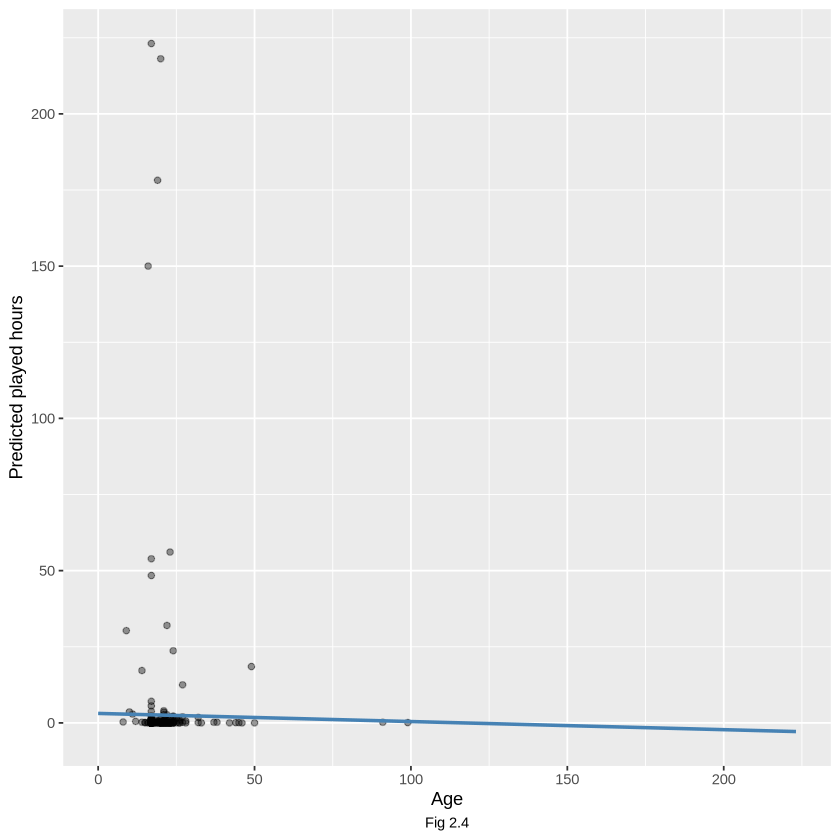

In [24]:
age_experience_grid <- tibble(
    age = seq(
        from = players_clean |> select(played_hours) |> min(),
        to = players_clean |> select(played_hours) |> max(),
        length.out = 100
    ),
    experience = mean(players_clean$experience)  # fix experience
)

age_experience_preds <- lm_fit |>
  predict(age_experience_grid) |>
  bind_cols(age_experience_grid)

lm_plot_final <- ggplot(players_clean, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +  
  geom_line(data = age_experience_preds,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +  
  labs(x = "Age", y = "Predicted played hours", caption = "Fig 2.4") +
  scale_y_continuous(labels = scales::comma_format()) +  
  theme(
          plot.title = element_text(hjust = 0.5),
          plot.caption = element_text(hjust = 0.5))

lm_plot_final


### Final result

In [25]:

print("LM fit on train datas")
lm_train_results


[1] "LM fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.622914


In [26]:
print("LM fit on test datas")
lm_test_results



[1] "LM fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.37322


In [27]:
print("Knn fit on train datas")
knn_summary_training


[1] "Knn fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.665761


In [28]:
print("Knn fit on test datas")
knn_summary_testing

[1] "Knn fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.13917


## **Discussion**

**Knn Classification**

After testing the model we trained, we found that it yielded a surprisingly high accuracy of about 0.80. We didn't expect age and experience to be very strong predictors of played_hours so we were suspicious about these results. 

To investigate this, we looked at the testing data (with predicted class) and added a new column of type boolean, that returns true if the predicted class was correct and false if the predicted class was incorrect. Plotting this data, we found that for all observations with a high played_hours, our model predicted incorrectly. We further investigated this by creating a summary table with groups of predicted class and values of count, to analyze the number of times our model made a prediction for each group. Looking at the results, we found that for our testing set of 49 observations, our model predicted (-inf, 1] played hours for 48 of them. The reason why our accuracy was so high was because the majority of our testing set was players in the (-inf, 1] played hours range.

The reason our model turned out this way is because when we transformed our played_hours variable into a categorical variable through binning, the bins were very unequal in number of observations. This scenario is not easy to work around, given our data set. While we arbitrarily set the number of bins and size of each bin, there is no way to create bins of similar numbers of observations. The original data set had a very large number of players who played under 1 hour. 

While one may suggest remodifying the data to exclude observations of players with 0 hours played, it wouldn't help us answer our main question for this project. Since we are interested in which players would contribute large amounts of hours, in converse, we care about which players wouldn't contribute large amounts of hours. Hence, it wouldn't make sense to discard data of players who didn't play.

A better solution would have been to perform knn classification with a non-linear weight function. We used "rectangular" for our model. However, the weight function should've been weighted to account for the imbalance in numbers of observations per class.

**Knn Regression**

When we plot our knn regression predictions as a line over our data, it appears to be a very weak model that just predicts somewhere near the mean played hours.

Knn regression yielded an RMSE of around 8 and a RMSPE of around 54. This disparity in RMSE vs RMSPE reflects a very weak model, since its predictions have much larger errors when ran on new data compared to the training data. This can most likely be explained by the underfit our model. We chose k based on values of k that gave us the lowest RMSE, but as a result we ended up with a very high k = 110. The RMSE is low because we chose the k with the lowest RMSE, however this model is very underfit (it is basically fit to the mean of the training data). Hence, when we have a different data set with a different mean, our model would be expected to yield a large error for a significant portion of the testing data.

Although we recognize that we chose a k that is too high for our model, there is no simple solution, since that was the k that gave us the lowest RMSE. When we plot RMSE vs k, we find that the RMSE generally decreases as k increases. There is no point where RMSE starts to increase. This suggests that maybe age and experience are not good predictors of hours played, since it would give us the least error if the model just predicts the mean hours_played for every observation, regardless of what the predictor variables are. 

One way we could've chosen a better k would be to consider the RMSE vs k plot again, but choose the k where the RMSE starts decreasing at an insignificant amount, based on our judgement. Looking at our RMSE vs k plot with this perspective, we probably would have gone with a k of around 14.

**Further Discussion**

We conclude that age and experience are not very good predictors of played hours. Therefore, the data we are given is insufficient in being able to answer the question of what "kinds" of players are likely to contribute large amounts of data. Therefore, we think that the researchers should consider more factors (variables) about the players, and collect data on those. This could be done by adding more questions for the players when they sign up, or by collecting data based on in-game behavior associated with the player. 

Here are potential ideas for factors that might be useful for predicting play time:
- geographical location
- preferred leisure activities
- amount of free time per week
- reason for signing up
- engagement in gaming communities
- other in-game behaviors
